## Prepare dataset

In [1]:
DATASET_NAME = "TopCow_all"
DATA_PATH = "/data/galati/brain_data/TopCoW_Data_MICCAI2023/topcow_batch-TOT/imagesTr/"

#these functions are to define for each new dataset, unless fixing a rule
#they allow to define a clear association between the data path of a brain image and the corresponding brain/vessel mask
#the brain mask is not mandatory, if not present just return None
import utils
def img_path_to_brain_path(img_path):
    return img_path.replace("imagesTr", "joined_masks_ct_whole").replace("_0000.nii.gz", "_brain_join_mask.nii.gz")
def img_path_to_weight_path(img_path):
    return img_path.replace("imagesTr", "roi_size_loc").replace("_ct_whole_", "_ct_roi_").replace("_0000.nii.gz", ".txt")
def img_path_to_vessel_path(img_path):
    return img_path.replace("imagesTr", "bin_labelsTr").replace("_0000.nii.gz", ".nii.gz")
utils.img_path_to_brain_path = img_path_to_brain_path
utils.img_path_to_weight_path = img_path_to_weight_path
utils.img_path_to_vessel_path = img_path_to_vessel_path

#this regex works as a filter in case you have unnecessary .nii files in your dataset folder
PATH_RULE = "^topcow\_ct\_whole\_[0-9]{3}\_0000.nii.gz$"

#if you have some outliers you want to discard, you can specify it in the list below
OUTLIERs = []

#if you need to preprocess also images with no vessel masks set the following flag to False
VESSELs_REQUIRED = True

#this parameter is to unify the orientation of our images
#set it True if you notice in the examples shown below that the nose is oriented downward and not upward
utils.do_flip = True

#this parameter is to specify whether to discard slices which do not contain any portion of the brain or keep them
DISCARD_EXTRA_SLICES = False

### Extract paths

In [2]:
import os

from utils import search_nii, extract_paths, load_info_from_checkpoint

In [3]:
if not os.path.isfile(f"info_{DATASET_NAME}.pkl"):
    info = {
        "train": extract_paths(path_rule=PATH_RULE),
        "val": None,
        "test": None,
    }
    search_nii(DATA_PATH, info["train"])
else:
    print("Loading info from ", f"info_{DATASET_NAME}.pkl")
    info = load_info_from_checkpoint(f"info_{DATASET_NAME}.pkl")

### Display examples

In [4]:
import random

from utils import print_bold, load_and_display_middle_slice

[Example 01]
<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b'r'
dim_info        : 0
dim             : [  3 307 384 214   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : int16
bitpix          : 16
slice_start     : 0
pixdim          : [1.         0.4453125  0.4453125  0.70000076 1.         1.
 1.         1.        ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 10
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b'Time=205850.645'
aux_file        : b''
qform_code      : unknown
sform_code      : aligned
quatern_b       : 0.0
quatern_c       : 0.0
quatern_d       : 1.0
qoffset_x       : 73.91797
qoffset_y

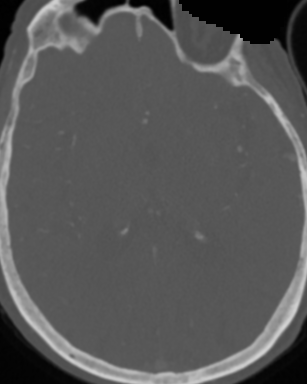

[Example 02]
<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b'r'
dim_info        : 0
dim             : [  3 286 379 202   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : int16
bitpix          : 16
slice_start     : 0
pixdim          : [1.         0.48242188 0.48242188 0.75       1.         1.
 1.         1.        ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 10
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b'Time=183308.910'
aux_file        : b''
qform_code      : unknown
sform_code      : aligned
quatern_b       : 0.0
quatern_c       : 0.0
quatern_d       : 1.0
qoffset_x       : 66.33301
qoffset_y

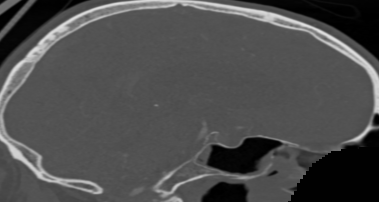

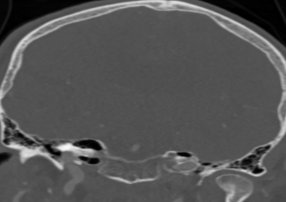

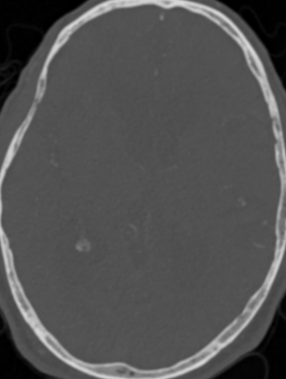

In [5]:
print_bold("[Example 01]")
random.seed(0)
load_and_display_middle_slice(random.choice(info["train"].paths), display_header=True)

print_bold("[Example 02]")
random.seed(1)
load_and_display_middle_slice(random.choice(info["train"].paths), axis=[0,1,2], display_header=True)

### Split train/val/test

In [6]:
from utils import is_medical_volume

In total, there are

In [7]:
IMGs = sum([
    info["train"].paths,
    info["val"].paths if info["val"] is not None else [],
    info["test"].paths if info["test"] is not None else []
], [])

len(IMGs)

90

volumes. First, we discard the outliers:

In [8]:
IMGs = [img_path for img_path in IMGs if os.path.basename(img_path) not in OUTLIERs]

len(IMGs)

90

We have vessel annotations for

In [9]:
HAVE_VESSELs = [
    img_path for img_path in IMGs if is_medical_volume(img_path_to_vessel_path(img_path))
]

len(HAVE_VESSELs)

90

of them. With a chosen ratio of 70-15-15, we select

In [10]:
COUNT_TEST = len(HAVE_VESSELs if VESSELs_REQUIRED else IMGs) * 15 // 100
COUNT_TEST

13

images to be part of the validation/testing set.

In case brain masks are available, we collect them too.

In [11]:
HAVE_BRAINs = [
    img_path for img_path in IMGs if is_medical_volume(img_path_to_brain_path(img_path))
]

len(HAVE_BRAINs)

90

The same for weight masks, delimitating the area for the calculation of losses and metrics. If available, we collect them.

In [12]:
HAVE_WEIGHTs = [
    img_path for img_path in IMGs if os.path.isfile(img_path_to_weight_path(img_path))
]

len(HAVE_WEIGHTs)

90

Finally, we randomly split our dataset. 

In [13]:
TEST_IMGs = [4,10,11,14,16,23,33,36,43,44,57,58,69]
TEST_IMGs = [os.path.join(DATA_PATH, "topcow_ct_whole_{:03d}_0000.nii.gz".format(i)) for i in TEST_IMGs]

random.seed(0)

VAL_IMGs = random.sample(sorted([img for img in HAVE_VESSELs if img not in TEST_IMGs]), COUNT_TEST)

print("val: ", [os.path.basename(img) for img in VAL_IMGs])

print("test: ", [os.path.basename(img) for img in TEST_IMGs])

TRAIN_IMGs = [img for img in (HAVE_VESSELs if VESSELs_REQUIRED else IMGs) if img not in VAL_IMGs and img not in TEST_IMGs]

val:  ['topcow_ct_whole_062_0000.nii.gz', 'topcow_ct_whole_066_0000.nii.gz', 'topcow_ct_whole_007_0000.nii.gz', 'topcow_ct_whole_042_0000.nii.gz', 'topcow_ct_whole_079_0000.nii.gz', 'topcow_ct_whole_076_0000.nii.gz', 'topcow_ct_whole_064_0000.nii.gz', 'topcow_ct_whole_049_0000.nii.gz', 'topcow_ct_whole_075_0000.nii.gz', 'topcow_ct_whole_056_0000.nii.gz', 'topcow_ct_whole_035_0000.nii.gz', 'topcow_ct_whole_078_0000.nii.gz', 'topcow_ct_whole_024_0000.nii.gz']
test:  ['topcow_ct_whole_004_0000.nii.gz', 'topcow_ct_whole_010_0000.nii.gz', 'topcow_ct_whole_011_0000.nii.gz', 'topcow_ct_whole_014_0000.nii.gz', 'topcow_ct_whole_016_0000.nii.gz', 'topcow_ct_whole_023_0000.nii.gz', 'topcow_ct_whole_033_0000.nii.gz', 'topcow_ct_whole_036_0000.nii.gz', 'topcow_ct_whole_043_0000.nii.gz', 'topcow_ct_whole_044_0000.nii.gz', 'topcow_ct_whole_057_0000.nii.gz', 'topcow_ct_whole_058_0000.nii.gz', 'topcow_ct_whole_069_0000.nii.gz']


### Extract spacings and shapes

In [14]:
from utils import extract_info_and_masks, loop_nii, display_info, get_target_spacing

In [15]:
info = {
    "train": extract_info_and_masks(path_rule=PATH_RULE),
    "val": extract_info_and_masks(path_rule=PATH_RULE),
    "test": extract_info_and_masks(path_rule=PATH_RULE),
}

loop_nii(TRAIN_IMGs, info["train"])
loop_nii(VAL_IMGs, info["val"])
loop_nii(TEST_IMGs, info["test"])

In [16]:
display_info(info["train"], info["val"])

,#volumes,#slices,spacing median,spacing range,shape median,shape range
TRAIN,64,13684,[000.44 000.44 000.70],[000.34 000.34 000.30] - [000.63 000.63 000.75],[306.50 378.50 206.50],[208.00 279.00 149.00] - [378.00 481.00 527.00]
VAL,13,2925,[000.45 000.45 000.75],[000.39 000.39 000.30] - [000.58 000.58 000.75],[300.00 366.00 205.00],[225.00 305.00 170.00] - [350.00 445.00 507.00]


In [17]:
SPACING = get_target_spacing(
    info["train"].spacings + info["val"].spacings,
    info["train"].shapesAfterCropping() + info["val"].shapesAfterCropping()
)

SPACING

array([0.4453125 , 0.4453125 , 0.70001221])

In [18]:
from utils import save_info_to_checkpoint

save_info_to_checkpoint(info, f"info_{DATASET_NAME}.pkl")

### Crop, Metadata, Resize, Empty Slices Removal, Standardization

In [19]:
from utils import load_info_from_checkpoint

info = load_info_from_checkpoint(f"info_{DATASET_NAME}.pkl")

In [20]:
import os

from utils import print_bold, preprocessing_loop

In [21]:
print_bold("Training")
preprocessing_loop(
    info["train"],
    os.path.join("numpy", "train"),
    target_spacing=SPACING,
    discard_extracerebral_slices=DISCARD_EXTRA_SLICES
)

print_bold("Validation")
preprocessing_loop(
    info["val"],
    os.path.join("numpy", "val"),
    target_spacing=SPACING,
    discard_extracerebral_slices=DISCARD_EXTRA_SLICES
)

print_bold("Testing")
preprocessing_loop(
    info["test"],
    os.path.join("numpy", "test"),
    target_spacing=SPACING,
    discard_extracerebral_slices=DISCARD_EXTRA_SLICES
)

Training
Slices processed: 217
Slices processed: 420
Slices processed: 615
Slices processed: 812
Slices processed: 1043
Slices processed: 1262
Slices processed: 1491
Slices processed: 1713
Slices processed: 1881
Slices processed: 2098
Slices processed: 2324
Slices processed: 2540
Slices processed: 2763
Slices processed: 2977
Slices processed: 3182
Slices processed: 3406
Slices processed: 3612
Slices processed: 3826
Slices processed: 4038
Slices processed: 4252
Slices processed: 4474
Slices processed: 4676
Slices processed: 4891
Slices processed: 5097
Slices processed: 5308
Slices processed: 5521
Slices processed: 5716
Slices processed: 5944
Slices processed: 6170
Slices processed: 6384
Slices processed: 6607
Slices processed: 6809
Slices processed: 7028
Slices processed: 7248
Slices processed: 7462
Slices processed: 7678
Slices processed: 7885
Slices processed: 8101
Slices processed: 8324
Slices processed: 8544
Slices processed: 8747
Slices processed: 8971
Slices processed: 9131
Slices

In [22]:
from utils import save_info_to_checkpoint

save_info_to_checkpoint(info, f"info_{DATASET_NAME}.pkl")

### Outliers removal and slices extraction

In [23]:
from utils import load_info_from_checkpoint

info = load_info_from_checkpoint(f"info_{DATASET_NAME}.pkl")

In [24]:
import os

from utils import print_bold, extraction_loop, display_slice

In [25]:
print_bold("Training")
extraction_loop(
    info["train"],
    os.path.join("slices", "train")
)

print_bold("Validation")
extraction_loop(
    info["val"],
    os.path.join("slices", "val")
)

print_bold("Testing")
extraction_loop(
    info["test"],
    os.path.join("slices", "test")
)

Training


100%|████████████████████████████████████████████████████████████████████████████████| 64/64 [00:19<00:00,  3.33it/s]


Validation


100%|████████████████████████████████████████████████████████████████████████████████| 13/13 [00:05<00:00,  2.32it/s]


Testing


100%|████████████████████████████████████████████████████████████████████████████████| 13/13 [00:06<00:00,  1.89it/s]


In [26]:
from utils import save_info_to_checkpoint

save_info_to_checkpoint(info, f"info_{DATASET_NAME}.pkl")

### Intensity values analysis

In [27]:
from utils import load_info_from_checkpoint

info = load_info_from_checkpoint(f"info_{DATASET_NAME}.pkl")

In [28]:
import numpy as np

from utils import intensity_loop, display_intensity
from utils import get_percentile, display_clipped_slice

Training


100%|████████████████████████████████████████████████████████████████████████████████| 64/64 [01:09<00:00,  1.09s/it]


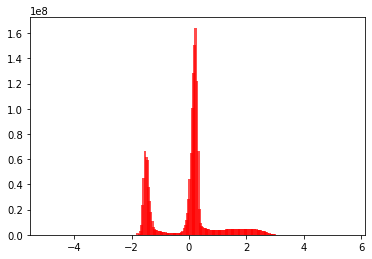

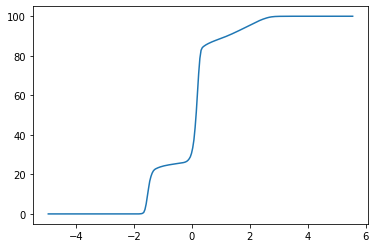

Validation


100%|████████████████████████████████████████████████████████████████████████████████| 13/13 [00:13<00:00,  1.05s/it]


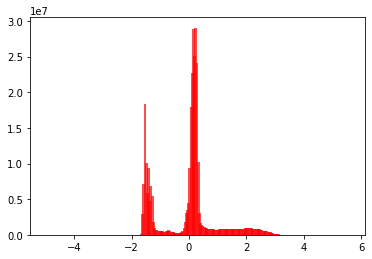

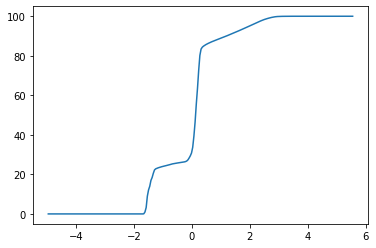

In [29]:
print_bold("Training")
intensity_loop(
    info["train"],
    min_value=min(info["train"].min_values + info["val"].min_values),
    max_value=max(info["train"].max_values + info["val"].max_values)
)
display_intensity(info["train"])

print_bold("Validation")
intensity_loop(
    info["val"],
    min_value=min(info["train"].min_values + info["val"].min_values),
    max_value=max(info["train"].max_values + info["val"].max_values)
)
display_intensity(info["val"])

In [30]:
MIN_VALUE = get_percentile(
    info["train"].bins,
    info["train"].intensity_count + info["val"].intensity_count,
    0.1
)
MAX_VALUE = get_percentile(
    info["train"].bins,
    info["train"].intensity_count + info["val"].intensity_count,
    99.9
)

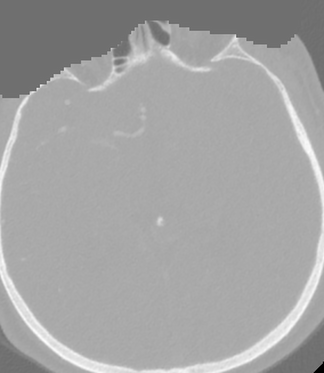

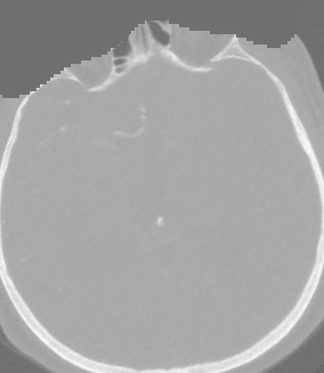

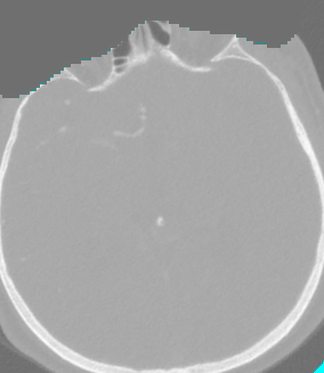

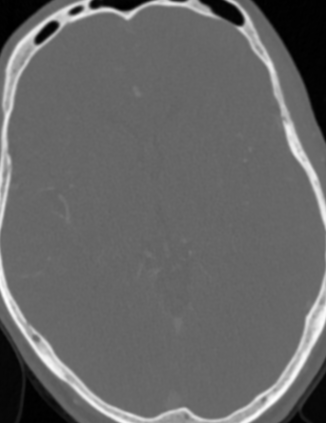

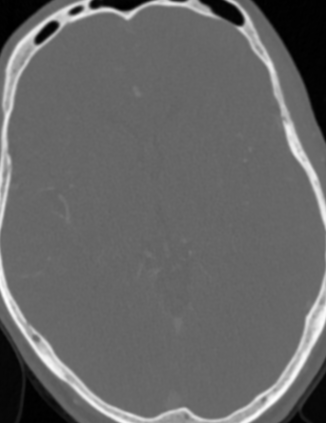

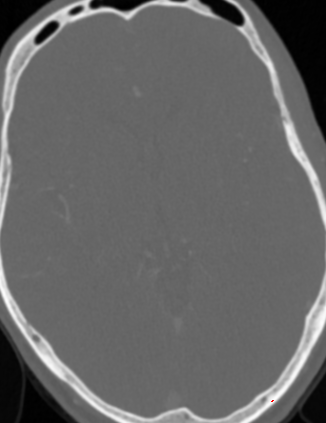

In [31]:
min_values_idx = np.argmin(
    info["train"].min_values + info["val"].min_values
)
DARK = (info["train"].preprocessed_paths + info["val"].preprocessed_paths)[min_values_idx]
DARK = DARK.replace("numpy/", "slices/").replace(".npy", "_slice{:03d}.npy").format(100)
display_clipped_slice(DARK, MIN_VALUE, MAX_VALUE)

max_values_idx = np.argmax(
    info["train"].max_values + info["val"].max_values
)
BRIGHT = (info["train"].preprocessed_paths + info["val"].preprocessed_paths)[max_values_idx]
BRIGHT = BRIGHT.replace("numpy/", "slices/").replace(".npy", "_slice{:03d}.npy").format(100)
display_clipped_slice(BRIGHT, MIN_VALUE, MAX_VALUE)

In [32]:
from utils import save_info_to_checkpoint

save_info_to_checkpoint(info, f"info_{DATASET_NAME}.pkl")

### Normalization, Padding & Cropping, One-Hot Encoding

In [33]:
from utils import load_info_from_checkpoint

info = load_info_from_checkpoint(f"info_{DATASET_NAME}.pkl")

In [34]:
import numpy as np

from utils import display_slice, normalization_loop

In [35]:
print_bold("Training")
normalization_loop(info["train"], f"preprocess_{DATASET_NAME}/train", MIN_VALUE, MAX_VALUE)

print_bold("Validation")
normalization_loop(info["val"], f"preprocess_{DATASET_NAME}/val", MIN_VALUE, MAX_VALUE)

print_bold("Testing")
normalization_loop(info["test"], f"preprocess_{DATASET_NAME}/test", MIN_VALUE, MAX_VALUE)

Training


100%|████████████████████████████████████████████████████████████████████████████████| 64/64 [04:50<00:00,  4.54s/it]


Validation


100%|████████████████████████████████████████████████████████████████████████████████| 13/13 [01:03<00:00,  4.91s/it]


Testing


100%|████████████████████████████████████████████████████████████████████████████████| 13/13 [01:00<00:00,  4.62s/it]


In [36]:
np.save(f"preprocess_map_{DATASET_NAME}.npy", {
    "train": sorted(os.listdir(f"preprocess_{DATASET_NAME}/train")),
    "val": sorted(os.listdir(f"preprocess_{DATASET_NAME}/val")),
    "test": sorted(os.listdir(f"preprocess_{DATASET_NAME}/test")),
})

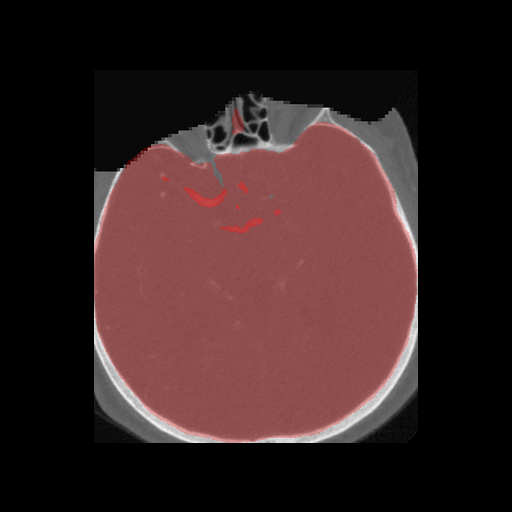

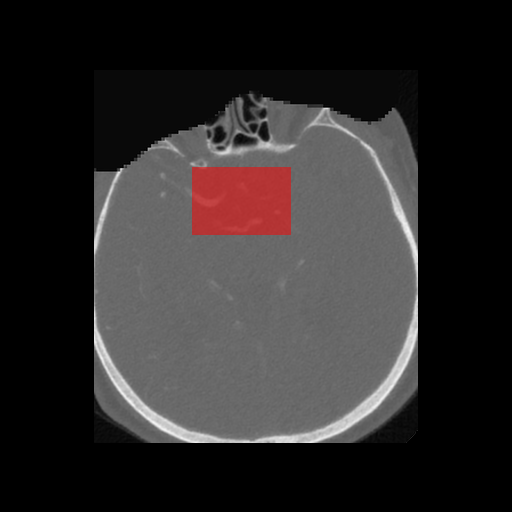

In [63]:
from PIL import Image

img_example = np.load(
    f"preprocess_{DATASET_NAME}/train/topcow_ct_whole_001_0000_slice095.npy", allow_pickle=True
).item()

img_example, msk_example, weight_example = img_example["data"][:,:,0], img_example["mask"], img_example["weight"]

msk_example = np.argmax(msk_example, axis=-1)
weight_example = weight_example.squeeze()

display_slice(img_example, min_val=-1, max_val=1, mask=msk_example/2)
display_slice(img_example, min_val=-1, max_val=1, mask=weight_example)